<a href="https://colab.research.google.com/github/nolifeking486/Vehicle-Classification-Using-Opencv/blob/main/Train_CustomModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook explains how to run YOLOv4 in cloud. 
First enable GPU in notebook settings. After that clone darknet.

In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

In [ ]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

In [ ]:
# make darknet (builds darknet so that you can then use the darknet executable file to run or train object detectors)
!make

YOLOv4 has been trained already on the coco dataset which has 80 classes that it can predict. We will grab these pretrained weights so that we can run YOLOv4 on these pretrained classes and get detections.

In [ ]:
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights

These three functions are helper functions that will allow you to show the image in your Colab Notebook after running your detections, as well as upload and download images to and from your Cloud VM.

In [ ]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

In [ ]:
# run darknet detection on test images
!./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights data/person.jpg

In [ ]:
# show image using our helper function
imShow('predictions.jpg')

Now we are done with installing darknet and checking if it's working properly. Now we can proceed to building our own custom detector.

We will be getting our files from Google Drive. We will also store the weights generated during training process in Google Drive so that if colab shuts down during training, we can continue from where we left off.


So first we will create a folder in Google Drive and name it yolov4. Inside it create another folder named backup. This is where are weights will be saved.
Inside yolov4 folder copy the files named generate_test.py, generate_train.py, obj.data, obj.names from https://github.com/nolifeking486/Vehicle-Classification-Using-Opencv/tree/main/yolov4

Also upload the dataset in the yolov4 folder. For this create a zip file containing all the training images and their labels in a single folder and name this file obj. Do this for validation images as well and name the zip file test. Now upload these two file in yolov4 folder in Google Drive.
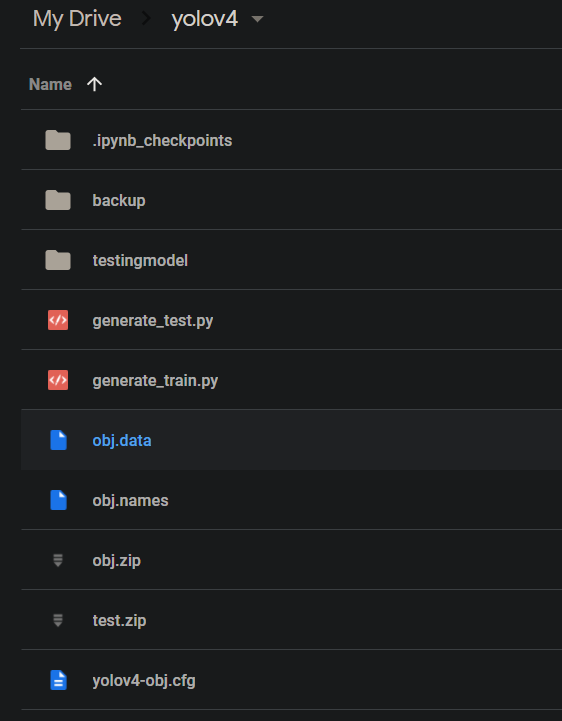

It should look like above image. Now mount your google drive.

In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# cd back into the darknet folder
%cd darknet

In [ ]:
# copy over both datasets into the root directory of the Colab VM (comment out test.zip if you are not using a validation dataset)
!cp /mydrive/yolov4/obj.zip ../
!cp /mydrive/yolov4/test.zip ../

In [ ]:
# unzip the datasets and their contents so that they are now in /darknet/data/ folder
!unzip ../obj.zip -d data/
!unzip ../test.zip -d data/

In [ ]:
# download cfg to google drive and change its name
!cp cfg/yolov4-custom.cfg /content/gdrive/MyDrive/yolov4/yolov4-obj.cfg

Now we need to make some changes in the cfg file. Use the built in Text Editor by going to your google drive and double clicking on yolov4-obj.cfg and then clicking on the Open with drop down and selectin Text Editor. 
Set width and height to 416.


max_batches = (# of classes) * 2000 (but no less than 6000 so if you are training for 1, 2, or 3 classes it will be 6000, however detector for 5 classes would have max_batches=10000)

steps = (80% of max_batches), (90% of max_batches) (so if your max_batches = 10000, then steps = 8000, 9000)

filters = (# of classes + 5) * 3 (so if you are training for one class then your filters = 18, but if you are training for 4 classes then your filters = 27)

In [ ]:
# upload the custom .cfg back to cloud VM from Google Drive
!cp /content/gdrive/MyDrive/yolov4/yolov4-obj.cfg ./cfg

Edit the contents of the obj.names and obj.data as per requirements.

In [ ]:
# upload the obj.names and obj.data files to cloud VM from Google Drive
!cp /content/gdrive/MyDrive/yolov4/obj.names ./data
!cp /content/gdrive/MyDrive/yolov4/obj.data  ./data

In [ ]:
# upload the generate_train.py and generate_test.py script to cloud VM from Google Drive
!cp /content/gdrive/MyDrive/yolov4/generate_test.py ./
!cp /content/gdrive/MyDrive/yolov4/generate_train.py ./

In [ ]:
# this will create two text files that hold the relative paths of training and validation images respectively
!python generate_train.py
!python generate_test.py

In [ ]:
# verify that the newly generated train.txt and test.txt can be seen in our darknet/data folder
!ls data/

This step downloads the weights for the convolutional layers of the YOLOv4 network. By using these weights it helps our custom object detector to be way more accurate and not have to train as long.

In [ ]:
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

In [ ]:
# train your custom detector! (uncomment %%capture below if you run into memory issues or your Colab is crashing)
# %%capture
!./darknet detector train data/obj.data cfg/yolov4-obj.cfg yolov4.conv.137 -dont_show -map

In [ ]:
# show chart.png of how custom object detector did with training
imShow('chart.png')

Run the following code if colab shuts down during training.

In [ ]:
# kick off training from where it last saved
!./darknet detector train data/obj.data cfg/yolov4-obj.cfg /mydrive/yolov4/backup/yolov4-obj_last.weights -dont_show

In [ ]:
# check mean average precision
!./darknet detector map data/obj.data cfg/yolov4-obj.cfg /mydrive/yolov4/backup/yolov4-obj_1000.weights